# House Prices - Advanced Regression Techniques

This Kaggle Competition provides 79 explanatory variables which describe characteristics of houses in Ames, Iowa. My goal is to predict the price of the house. This is quite relevant, as where I live (near Toronto), house prices are skyrocketing! It would be interesting to see which factors are particularly relevant in the Ames housing market, maybe it is similar to Toronto. 

I will use the Root Mean Squared Logarithmi Error as my accuracy metric of choice. This will penalize an estimate that under-predicts the price much more than one that over-predicts the price. 

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import xgboost as xgb
%matplotlib inline 
sns.set_style('whitegrid')

import scipy.stats as stats
from scipy import stats
from scipy.stats import pointbiserialr, spearmanr, skew, pearsonr

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn import linear_model
import shap

In [ ]:
Dtrain = pd.read_csv("train.csv")
Dtest = pd.read_csv("test.csv")

In [ ]:
Dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
Dtrain.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [ ]:
Dtrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We have many categorical variables and NaN values. What does NaN mean in this case? For instance what does NaN mean in the context of the `street` feature? The NaN value could just mean the absence of an attribute (no street accesible to the house)

## Handling our missing Data

Which columns actually have missing data

In [ ]:
Dtrain[Dtrain.columns[Dtrain.isnull().sum() > 0].tolist()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    1452 non-null   object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

In [ ]:
train_list = Dtrain.columns[Dtrain.isnull().sum() > 0].tolist()
test_list = Dtest.columns[Dtest.isnull().sum() > 0].tolist()
# Columns that are in test but not in train
Dtest[list(i for i in test_list if i not in train_list)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      1455 non-null   object 
 1   Utilities     1457 non-null   object 
 2   Exterior1st   1458 non-null   object 
 3   Exterior2nd   1458 non-null   object 
 4   BsmtFinSF1    1458 non-null   float64
 5   BsmtFinSF2    1458 non-null   float64
 6   BsmtUnfSF     1458 non-null   float64
 7   TotalBsmtSF   1458 non-null   float64
 8   BsmtFullBath  1457 non-null   float64
 9   BsmtHalfBath  1457 non-null   float64
 10  KitchenQual   1458 non-null   object 
 11  Functional    1457 non-null   object 
 12  GarageCars    1458 non-null   float64
 13  GarageArea    1458 non-null   float64
 14  SaleType      1458 non-null   object 
dtypes: float64(8), object(7)
memory usage: 171.1+ KB


In [ ]:
# Columns that are in train but not in test
Dtrain[list(i for i in train_list if i not in test_list)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Electrical  1459 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


Intuitively, it would make sense if the following columns meant an absence of the variable:

- `MiscFeature` 
- `Fence` 
- `Alley`
- `MasVnrType` (Masonry veneer type)
- `MasVnrArea` (Masonry veneer area)
- `PoolQC` 
- `KitchenQual`
- `FireplaceQu` 
- `BsmtQual` 
- `BsmtCond` 
- `BsmtExposure` 
- `BsmtFinType1` (Quality of basmenet finished area)
- `BsmtFinType2` (Quality of basmenet finished area)
- `BsmtFinSF1`/`BsmtFinSF2` (Area of finished basement)
- `BsmtUnfSF` (Unfinished square feet of basement area)


For the other variables, we should maybe replace the missing values with something more meaningful. These variables are

- MSZoning (The general zoning classification);
- Utilities;
- Exterior1st and Exterior2nd (Exterior covering on house);
- KitchenQual;
- Functional (Home functionality rating);
- SaleType;
- Electrical;
- LotFrontage;
- GarageCars and GarageArea;

In [ ]:
# Now we will replace the NA values in some of these features with either 0 or None

col_to_null = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath',
           'PoolQC', 'Fence', 'MiscFeature']

for col in col_to_null:
  if Dtrain[col].dtype == "object":
    Dtrain[col].fillna('None', inplace = True)
    Dtest[col].fillna('None', inplace = True)

  else:
    Dtrain[col].fillna(0,inplace=True)
    Dtest[col].fillna(0,inplace=True)   


In [ ]:
Dtrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [ ]:
#Fill NA with common values.
Dtest.loc[Dtest.KitchenQual.isnull(), 'KitchenQual'] = 'TA'
Dtest.loc[Dtest.MSZoning.isnull(), 'MSZoning'] = 'RL'
Dtest.loc[Dtest.Utilities.isnull(), 'Utilities'] = 'AllPub'
Dtest.loc[Dtest.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'
Dtest.loc[Dtest.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'
Dtest.loc[Dtest.Functional.isnull(), 'Functional'] = 'Typ'
Dtest.loc[Dtest.SaleType.isnull(), 'SaleType'] = 'WD'
Dtrain.loc[Dtrain['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
Dtrain.loc[Dtrain['LotFrontage'].isnull(), 'LotFrontage'] = Dtrain['LotFrontage'].mean()
Dtest.loc[Dtest['LotFrontage'].isnull(), 'LotFrontage'] = Dtest['LotFrontage'].mean()


In [ ]:
# In many cases, a categorical variable with 'None' should really by zero. So I replace that here
Dtrain.loc[Dtrain.MasVnrType == 'None', 'MasVnrArea'] = 0
Dtest.loc[Dtest.MasVnrType == 'None', 'MasVnrArea'] = 0
Dtest.loc[Dtest.BsmtFinType1=='None', 'BsmtFinSF1'] = 0
Dtest.loc[Dtest.BsmtFinType2=='None', 'BsmtFinSF2'] = 0
Dtest.loc[Dtest.BsmtQual=='None', 'BsmtUnfSF'] = 0
Dtest.loc[Dtest.BsmtQual=='None', 'TotalBsmtSF'] = 0

In [ ]:
Dtrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [ ]:
Dtest.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,...,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,...,0,0,None,MnPrv,None,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,...,144,0,None,None,None,0,1,2010,WD,Normal


In [ ]:
Dtest.loc[Dtest.GarageCars.isnull(), 'GarageCars'] = 0
Dtest.loc[Dtest.GarageArea.isnull(), 'GarageArea'] = 0


## Data Visualization

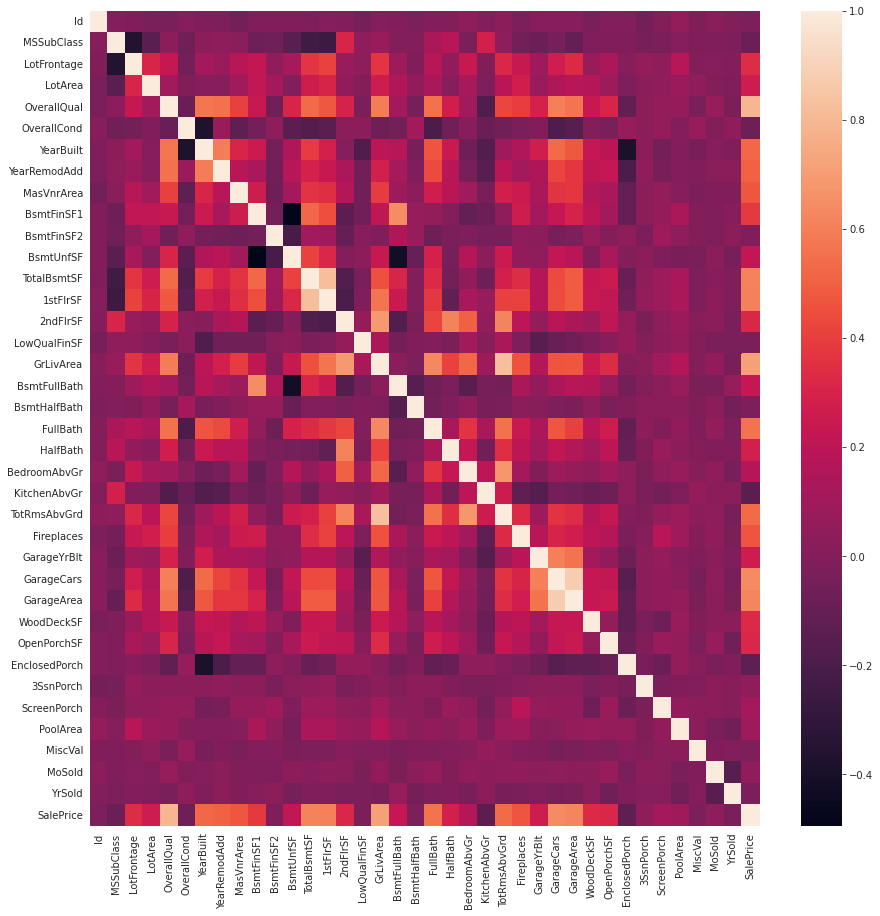

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(Dtrain.corr(), vmax = 1)

`sns.heatmap()` will only show me data for pairings of numerical values. Let's also look at categoricals and see the highest correlations

In [ ]:
threshold = 0.8 # Threshold value.
# Function for computing correlations taken from online source
def correlation():
    for i in Dtrain.columns:
        for j in Dtrain.columns[list(Dtrain.columns).index(i) + 1:]: #Ugly, but works. This way there won't be repetitions.
            if Dtrain[i].dtype != 'object' and Dtrain[j].dtype != 'object':
                #pearson is used by default for numerical.
                if abs(pearsonr(Dtrain[i], Dtrain[j])[0]) >= threshold:
                    yield (pearsonr(Dtrain[i], Dtrain[j])[0], i, j)
            else:
                #spearman works for categorical.
                if abs(spearmanr(Dtrain[i], Dtrain[j])[0]) >= threshold:
                    yield (spearmanr(Dtrain[i], Dtrain[j])[0], i, j)


In [ ]:
list(correlation())

[(0.858487256763469, 'Exterior1st', 'Exterior2nd'),
 (-0.8960687885891644, 'BsmtFinType2', 'BsmtFinSF2'),
 (0.819529975005033, 'TotalBsmtSF', '1stFlrSF'),
 (0.8254893743088428, 'GrLivArea', 'TotRmsAbvGrd'),
 (0.8824754142814624, 'GarageCars', 'GarageArea'),
 (-0.9999911109711233, 'PoolArea', 'PoolQC'),
 (0.9028952966055307, 'MiscFeature', 'MiscVal')]

This is actually pretty reasonable! Obviously the number of cars in a garage would be correlated with the area of the garage. Many of these pairings are referring to a similar topic or construct. 

In [ ]:
# Let's look for some interesting patterns in the data
Dtrain.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

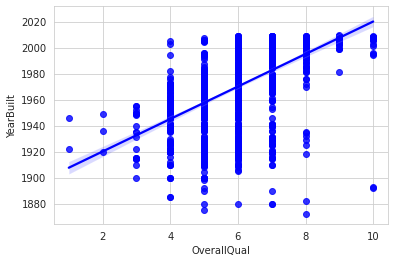

In [ ]:
sns.regplot(x = 'OverallQual', y = 'YearBuilt', data = Dtrain, color = 'Blue')

There is perhaps less of a correlation between the year built and overall quality of the house. This may be counterintuitive, but maybe there is substantial maintenance and renovation in many of these houses.

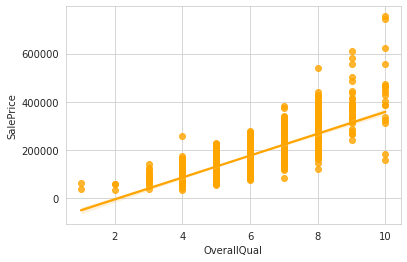

In [ ]:
sns.regplot(x='OverallQual', y='SalePrice', data=Dtrain, color='Orange')


This makes sense, as it is obvious that the quality of a house should be correlated with its price. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


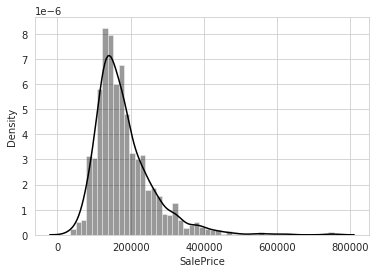

In [ ]:
sns.distplot(Dtrain.SalePrice, kde = True, color = 'k')

Sale Prices are clearly skewed, maybe it would be worthwile to transform our data. Very expensive houses could be very important in our analysis.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

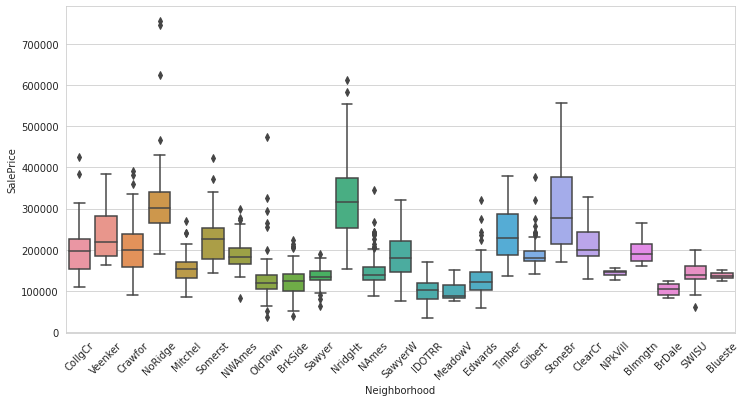

In [ ]:
plt.figure(figsize = (12, 6))
sns.boxplot(x='Neighborhood', y='SalePrice',  data=Dtrain)
plt.xticks(rotation=45)

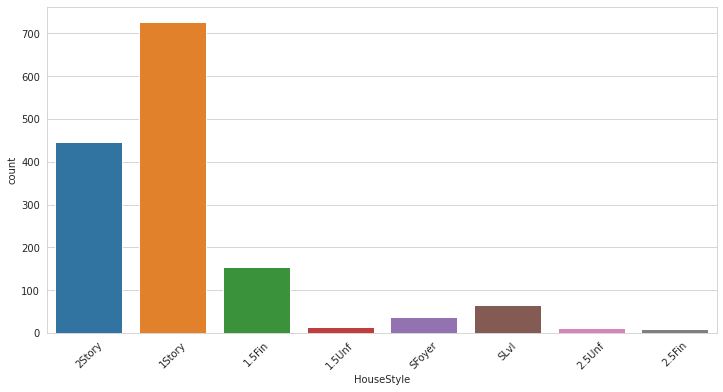

In [ ]:
plt.figure(figsize = (12, 6))
sns.countplot(x='HouseStyle', data=Dtrain)
xt = plt.xticks(rotation=45)

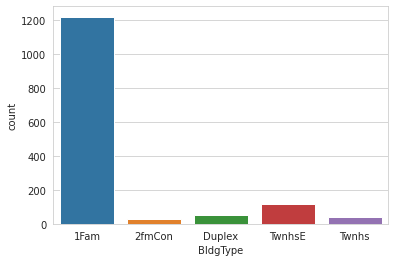

In [ ]:
sns.countplot(x = 'BldgType', data = Dtrain)

So the vast majority of houses are one-family and two-story.

## Data Preparation

In [ ]:
# Could use get_dummies to make a one-hot encoding but will convert to categories just by making it a string
# Will use pd.get_dummies in the next step
Dtrain.MSSubClass = Dtrain.MSSubClass.astype(str)
Dtest.MSSubClass = Dtest.MSSubClass.astype(str)

In [ ]:
for col in Dtrain.columns:
  if Dtrain[col].dtype != 'object':
    if skew(Dtrain[col]) > 0.75:
      Dtrain[col] = np.log1p(Dtrain[col])
  else:

    df = pd.get_dummies(Dtrain[col], drop_first = True)
    df = df.add_prefix("{}_".format(col))
    Dtrain.drop(col, axis = 1, inplace = True)
    Dtrain = Dtrain.join(df)

for testcol in Dtest.columns:
  if Dtest[testcol].dtype != 'object':
    if skew(Dtest[testcol]) > 0.75:
      Dtest[testcol] = np.log1p(Dtest[testcol])
    
  else:
    df = pd.get_dummies(Dtest[testcol], drop_first = True)
    df = df.add_prefix("{}_".format(testcol))
    Dtest.drop(testcol, axis = 1, inplace = True)
    Dtest  = Dtest.join(df)



  

In [ ]:
X_train = Dtrain.drop('SalePrice', axis = 'columns')
y_train = Dtrain.SalePrice 
X_test = Dtest.copy()

# Building a Model

I will use the Root Mean Squared Logarithmic Error, or 

$$
\epsilon = \sqrt{\frac{1}{n} ∑_{i = 1}^n (\log{(p_i + 1)} - \log{(a_i +1)})^2}
$$

where $n$ is the number of observations, $p_i$ is the predicted output, and $a_i$ is the actual output.

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, random_state = 0, test_size = 0.3) 

In [ ]:
def rmlse(val, target):
    return np.sqrt(np.sum(((np.log1p(val) - np.log1p(np.expm1(target)))**2) / len(target)))

## Ridge Regression

A linear regression model regularized by the L2 norm.

In [ ]:
ridge = Ridge(alpha = 1.0, solver = 'auto').fit(Xtrain, ytrain)
ridge_pred = np.expm1(ridge.predict(Xtest))
print("The RMLSE for Ridge Regression with alpha = 1.0 is {:.4f}".format(rmlse(ridge_pred, ytest)))

The RMLSE for Ridge Regression with alpha = 1.0 is 0.1507


In [ ]:
ridge_cv = RidgeCV(alphas = (0.01, 0.05, 0.10, 0.20, 0.50, 1, 2, 4,10))
ridge_cv.fit(Xtrain, ytrain)
ridge_cv_pred = np.expm1(ridge_cv.predict(Xtest))
print("The RMLSE for Ridge Regression with CV is {:.4f} with an alpha of {:.2f}".format(rmlse(ridge_cv_pred, ytest), ridge_cv.alpha_))

The RMLSE for Ridge Regression with CV is 0.1392 with an alpha of 10.00


## Lasso Regression
A linear regression model regularized by the L1 norm

In [ ]:
lasso = linear_model.Lasso(alpha = 0.0005)
lasso.fit(Xtrain, ytrain)
las_pred = np.expm1(lasso.predict(Xtest))
print("The RMLSE for Lasso Regression with alpha = 0.0005 is {:.4f}".format(rmlse(las_pred, ytest)))

The RMLSE for Lasso Regression with alpha = 0.0005 is 0.1414


In [ ]:
lasso_cv = LassoCV(alphas = (0.0001, 0.0005, 0.001, 0.01, 0.1, 1.0, 2.0, 3.0, 4.0, 5.0))
lasso_cv.fit(Xtrain, ytrain)
las_pred_cv = np.expm1(lasso_cv.predict(Xtest))
print("The RMLSE for Lasso Regression with CV is {:.4f} with an alpha of {:.4f}".format(rmlse(las_pred_cv, ytest), lasso_cv.alpha_))

The RMLSE for Lasso Regression with CV is 0.1414 with an alpha of 0.0005


## XGB Regression Model

First we want to tune our parameters using cross-validation

In [ ]:
# Define the XGB Model
xgb_model = xgb.XGBRegressor(max_depth=3,                 # Depth of each tree
                          learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                          n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                          boostXGBer='gbtree',             # What to boost. Trees in this case.
                          gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                          subsample=0.632,              # Subsample ratio. Can set lower
                          colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                          colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                          colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                          reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                          reg_lambda=0,                 # Regularizer for first fit.
                          random_state=20220524,        # Seed
                          )

In [ ]:
# We will do a grid search
param_grid = dict({'n_estimators': [350, 400, 450, 500],
                   'max_depth': [2, 3, 4, 5, 6, 7],
                   'learning_rate' : [0.01, 0.1, 0.2, 0.3]
                  })

# Define grid search object.
GridXGB = GridSearchCV(xgb_model,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = rmlse,   # How to rank outputs.
                       n_jobs = -1,         # Parallel jobs. -1 is "all you have" Careful, never clash threads. Either paralellize XGB OR this, NOT both.
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 0         # If to show what it is doing.
                      )         

In [ ]:
GridXGB.fit(Xtrain, ytrain) # Will take some time to run

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  category=UserWarning,


GridSearchCV(cv=3,
             estimator=XGBRegressor(boostXGBer='gbtree', gamma=0.001,
                                    random_state=20220524, reg_alpha=1,
                                    reg_lambda=0, subsample=0.632),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [350, 400, 450, 500]},
             refit=False, scoring=<function rmlse at 0x7f915a97f830>)

In [ ]:
GridXGB.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 350}

In [ ]:
xgb_model = xgb.XGBRegressor(max_depth = 2,
                             learning_rate = 0.01,
                             n_estimators = 350)
xgb_model.fit(Xtrain, ytrain)
xgb_preds = np.expm1(xgb_model.predict(Xtest))
print("The RMLSE for an XGB Regressor is {:.4f}".format(rmlse(xgb_preds, ytest)))

[22:23:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The RMLSE for an XGB Regressor is 0.3854


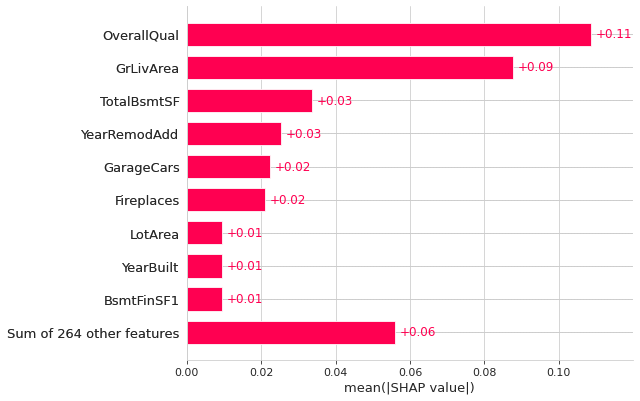

In [ ]:
import shap
explainer = shap.Explainer(xgb_model)
shap_values = explainer(Xtest)

# Report the average importances.
shap.plots.bar(shap_values)

SHAP is a local method of measuring importance because it looks over subsamples and averages over all cases. SHAP is better because it is a contribution at a CASE level (how the cases change), rather than say, a tree level. 

From SHAP documentation:

"The above figure shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue."

## Random Forest Regressor

In [ ]:
forest = RandomForestRegressor(min_samples_split =5,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = None,
                                max_depth = None,
                                n_estimators = 300,
                                max_features = 'auto')

forest.fit(Xtrain, ytrain)
Y_pred_RF = np.expm1(forest.predict(Xtest))
rmlse(Y_pred_RF, ytest)

0.13431878769836356

So linear models are much better than the non-linear models we have tested. Though Ridge is better than Lasso, I want to see the variable importance as well. Since Lasso uses the L1 norm, many feature coefficients will tend to zero, so we can see which variables are the most relevant. 

In [ ]:
relevant_vars = np.sum(lasso_cv.coef_ != 0)
print("There are", relevant_vars, "relevant variables")

There are 110 relevant variables


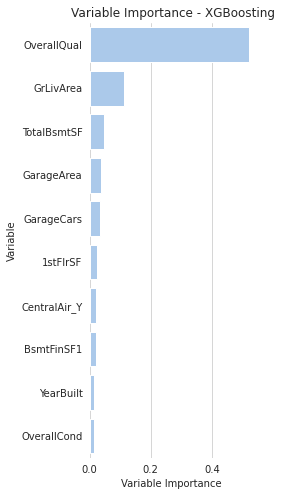

In [ ]:
# Variable importances using random forest model
importances = forest.feature_importances_  # Change model object
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y= [Xtrain.columns[i] for i in indices][:10], x=importances[indices][:10], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance ")
sns.despine(left=True, bottom=True)

I will make a model that combines both XGBoost and Lasso. Even though Ridge was better, the difference was marginal and I want to minimize the number of features used (more coefficients to zero), so I will use lasso.

In [ ]:
las_cv1 = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
las_cv1.fit(Xtrain, ytrain)
lasso_preds = np.expm1(las_cv1.predict(Xtest))

#I added XGBoost as it usually improves the predictions.
model_xgb = xgb.XGBRegressor(n_estimators=350, max_depth=2, learning_rate=0.1)
model_xgb.fit(Xtrain, ytrain)
xgb_preds = np.expm1(model_xgb.predict(Xtest))


[22:23:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
pred  = 0.3 * xgb_preds + 0.7 * lasso_preds

In [ ]:
final = pd.DataFrame({"ID": Xtest.Id,
              "House Price": pred})

In [ ]:
final.to_csv("final_house_price.csv")

In [ ]:
final

,ID,House Price
529,530,226504.997838
491,492,155130.991626
459,460,124367.419637
279,280,226488.509893
655,656,87826.782541
...,...,...
271,272,217581.245778
445,446,151721.658864
654,655,349966.337940
1280,1281,211011.268436
